In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_auc_score
from imblearn.combine import SMOTEENN


# Carregar os dados
file_path_normal = r'C:\Users\Andre\Downloads\DOUTORADO\kanormais.xlsx'  # Substitua pelo caminho correto
file_path_anomalous = r'C:\Users\Andre\Downloads\DOUTORADO\kaanomalos5.xlsx'  # Substitua pelo caminho correto

# Carregar os dados normais e anômalos
normais = pd.read_excel(file_path_normal)
anomalos = pd.read_excel(file_path_anomalous)

normais = normais.to_numpy()
anomalos = anomalos.to_numpy()

# Pré-processamento de dados
scaler = StandardScaler()

# Ajustar o scaler nos dados normais (apenas treino usa fit_transform)
normais_scaled = scaler.fit_transform(normais)

# Transformar os dados anômalos para o mesmo espaço
anomalos_scaled = scaler.transform(anomalos)

# Concatenar os dados normais e anômalos para treinar o modelo
X = np.concatenate([normais_scaled, anomalos_scaled], axis=0)

# Labels: 0 para normais e 1 para anômalos
y = np.concatenate([np.zeros(len(normais)), np.ones(len(anomalos))])

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



In [15]:
# Rebalanceamento do Dataset com SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Divisão dos dados para treinamento e validação
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

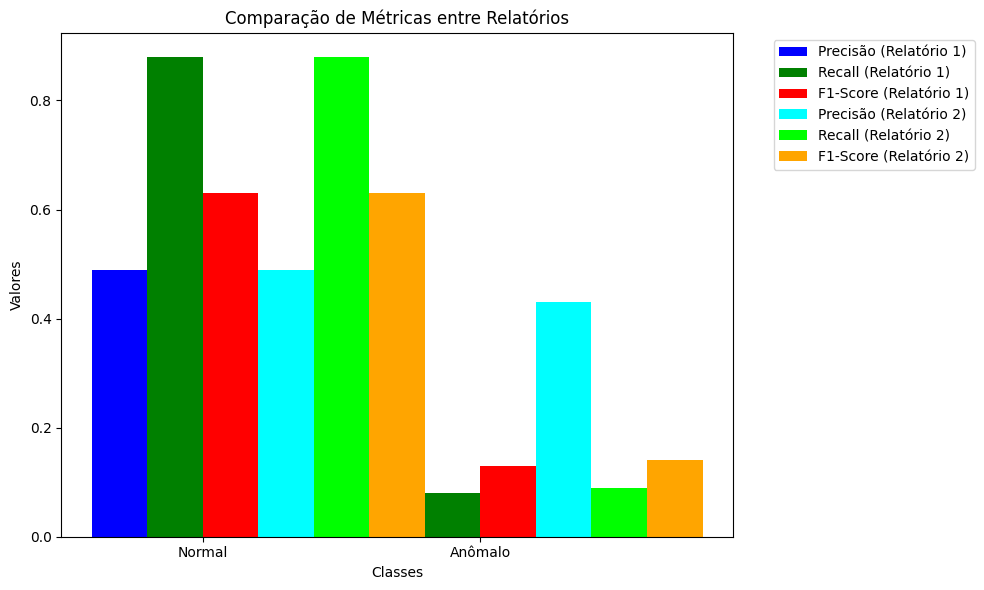

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Dados do primeiro relatório
classes_1 = ["Normal", "Anômalo"]
precision_1 = [0.49, 0.39]
recall_1 = [0.88, 0.08]
f1_score_1 = [0.63, 0.13]

# Dados do segundo relatório
classes_2 = ["Normal", "Anômalo"]
precision_2 = [0.49, 0.43]
recall_2 = [0.88, 0.09]
f1_score_2 = [0.63, 0.14]

# Configurações do gráfico
x = np.arange(len(classes_1))
width = 0.2  # Largura das barras

fig, ax = plt.subplots(figsize=(10, 6))

# Gráficos do primeiro relatório
ax.bar(x - width, precision_1, width, label='Precisão (Relatório 1)', color='blue')
ax.bar(x, recall_1, width, label='Recall (Relatório 1)', color='green')
ax.bar(x + width, f1_score_1, width, label='F1-Score (Relatório 1)', color='red')

# Gráficos do segundo relatório
ax.bar(x + 2*width, precision_2, width, label='Precisão (Relatório 2)', color='cyan')
ax.bar(x + 3*width, recall_2, width, label='Recall (Relatório 2)', color='lime')
ax.bar(x + 4*width, f1_score_2, width, label='F1-Score (Relatório 2)', color='orange')

# Configurações adicionais
ax.set_xlabel('Classes')
ax.set_ylabel('Valores')
ax.set_title('Comparação de Métricas entre Relatórios')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(classes_1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.tight_layout()
plt.show()


In [9]:
#Criando o Autoencoder
autoencoder = Sequential()

# Camada de codificação
autoencoder.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))  # 64 neurônios
autoencoder.add(Dense(32, activation='relu'))  # 32 neurônios

# Camada de codificação intermediária
autoencoder.add(Dense(16, activation='relu'))  # 16 neurônios

# Camada de decodificação
autoencoder.add(Dense(32, activation='relu'))
autoencoder.add(Dense(64, activation='relu'))

# Camada de saída (mesmo número de features dos dados)
autoencoder.add(Dense(X_train.shape[1], activation='sigmoid'))

# Compilar o modelo
autoencoder.compile(optimizer='adam', loss='mse')

# Treinar o modelo
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

# 4. Fazendo a detecção de anomalias
# Obter a reconstrução dos dados de teste
X_test_reconstructed = autoencoder.predict(X_test)

# Calcular o erro de reconstrução (diferença entre o original e a reconstrução)
reconstruction_error = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)

# Usar um limiar para classificar as anomalias
threshold = np.percentile(reconstruction_error, 95)  # Definir limiar como 95% do erro

# Classificar como anômalo se o erro de reconstrução for maior que o limiar
y_pred = (reconstruction_error > threshold).astype(int)



Epoch 1/50


c:\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.1851 - val_loss: 1.1205
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0198 - val_loss: 0.9005
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8352 - val_loss: 0.7858
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7498 - val_loss: 0.7366
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7032 - val_loss: 0.6824
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6584 - val_loss: 0.6607
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6335 - val_loss: 0.6499
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6209 - val_loss: 0.6400
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6180 - val_loss: 0.6257
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6087 - val_loss: 0.6142
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5968 - val_loss: 0.6076
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5824 - val_loss: 0.6040

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


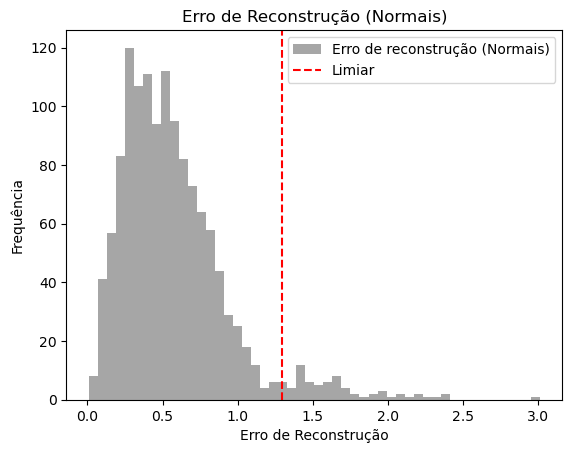

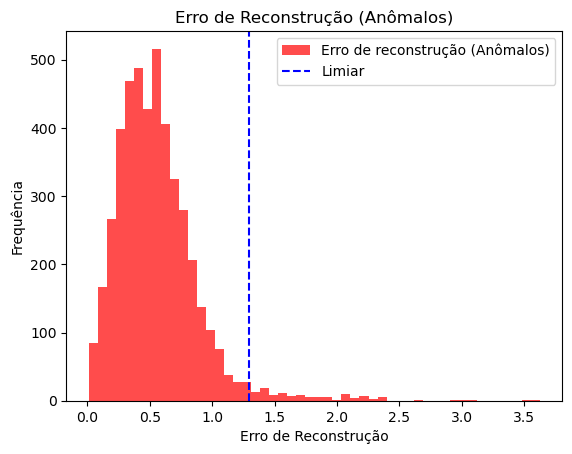

Número de anomalias detectadas nos dados normais: 66
Número de anomalias detectadas nos dados anômalos: 127


In [10]:
# Calcular o erro de reconstrução para os dados normais e anômalos
reconstruction_error = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)
reconstruction_error_anomalous = np.mean(np.power(anomalos_scaled - autoencoder.predict(anomalos_scaled), 2), axis=1)

# Definir o limiar com base no erro de reconstrução dos dados normais
threshold = np.percentile(reconstruction_error, 95)  # Ajuste o limiar conforme necessário

# Classificar como anômalo se o erro de reconstrução for maior que o limiar
y_pred_test = (reconstruction_error > threshold).astype(int)
y_pred_anomalous = (reconstruction_error_anomalous > threshold).astype(int)

# Visualizar o erro de reconstrução para normais
plt.hist(reconstruction_error, bins=50, color='gray', alpha=0.7, label="Erro de reconstrução (Normais)")
plt.axvline(x=threshold, color='red', linestyle='--', label="Limiar")
plt.legend()
plt.title("Erro de Reconstrução (Normais)")
plt.xlabel("Erro de Reconstrução")
plt.ylabel("Frequência")
plt.show()

# Visualizar o erro de reconstrução para anômalos
plt.hist(reconstruction_error_anomalous, bins=50, color='red', alpha=0.7, label="Erro de reconstrução (Anômalos)")
plt.axvline(x=threshold, color='blue', linestyle='--', label="Limiar")
plt.legend()
plt.title("Erro de Reconstrução (Anômalos)")
plt.xlabel("Erro de Reconstrução")
plt.ylabel("Frequência")
plt.show()

# Exibir as quantidades de anomalias detectadas
print(f"Número de anomalias detectadas nos dados normais: {np.sum(y_pred_test)}")
print(f"Número de anomalias detectadas nos dados anômalos: {np.sum(y_pred_anomalous)}")


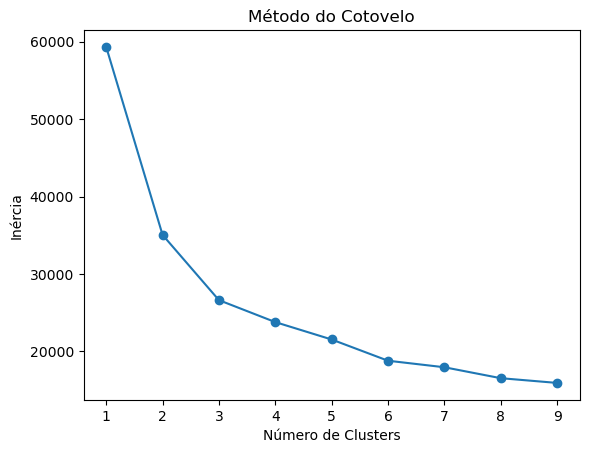

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.20      0.75      0.31       682
     Anômalo       0.42      0.06      0.10      2233

    accuracy                           0.22      2915
   macro avg       0.31      0.40      0.20      2915
weighted avg       0.37      0.22      0.15      2915



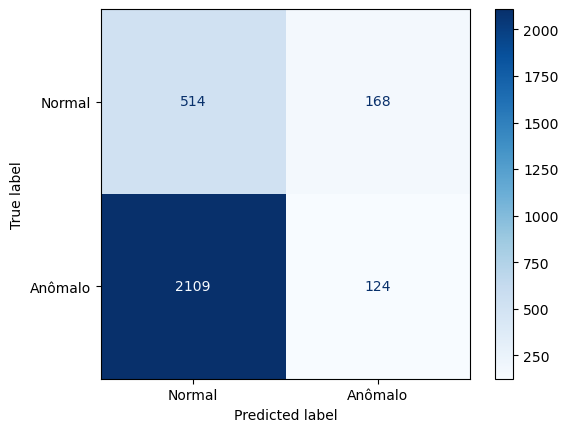

Métricas de Performance:
Silhouette Score: 0.3651998561802573
Calinski-Harabasz Score: 2018.8174378358792
Threshold para anomalias: 4.758637535582687
Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.55      0.94      0.70       467
     Anômalo       0.70      0.15      0.24       421

    accuracy                           0.57       888
   macro avg       0.62      0.54      0.47       888
weighted avg       0.62      0.57      0.48       888



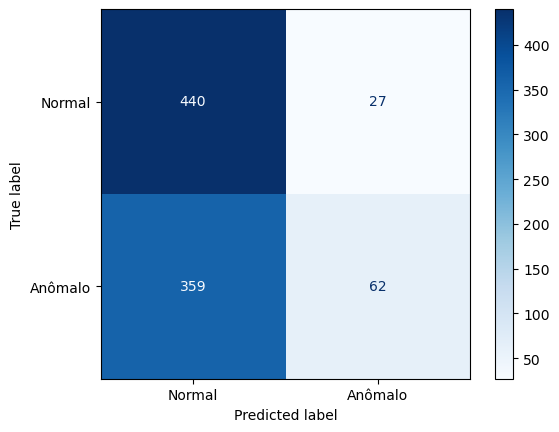

Métricas de Performance:
Silhouette Score: 0.37338168865749566
Calinski-Harabasz Score: 2457.8337131364497
Threshold para anomalias: 4.818650151976914


In [16]:

#Kmeans

from imblearn.combine import SMOTEENN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    silhouette_score, calinski_harabasz_score
)

# Pré-processamento dos dados
X_scaled = X

# Função para calcular métricas do KMeans
def calculate_kmeans_metrics(X, labels):
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    return silhouette, calinski

# Função para detectar anomalias
def detect_anomalies(X, centroids, labels, percentile=90):
    distances = np.linalg.norm(X - centroids[labels], axis=1)
    threshold = np.percentile(distances, percentile)
    anomalies = distances > threshold
    return anomalies.astype(int), threshold


# Determinar o número ideal de clusters (opcional)
# Método do cotovelo
inertia = []
for k in range(1, 10):
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans_temp.fit(X_scaled)
    inertia.append(kmeans_temp.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

# Configurando o K-Means com novos parâmetros
kmeans = KMeans(
    n_clusters=2,         # Número de clusters
    init="k-means++",     # Inicialização inteligente
    max_iter=500,         # Número máximo de iterações
    n_init=10,            # Número de inicializações
    random_state=42,      # Semente aleatória
    tol=1e-5,             # Tolerância para convergência
    algorithm="elkan"     # Algoritmo eficiente
)

# Treinamento do K-Means
labels = kmeans.fit_predict(X_scaled)
centroids = kmeans.cluster_centers_

# Métricas do K-Means
silhouette, calinski = calculate_kmeans_metrics(X_scaled, labels)

# Salvar resultados de performance
performance_results = {
    "K-Means": {
        "Silhouette Score": silhouette,
        "Calinski-Harabasz Score": calinski
    }
}

# Detectar anomalias
y_pred, threshold = detect_anomalies(X_scaled, centroids, labels, percentile=90)

# Avaliação
print("Relatório de Classificação:")
print(classification_report(y, y_pred, target_names=["Normal", "Anômalo"]))

# Matriz de Confusão
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anômalo"])
disp.plot(cmap='Blues')
plt.show()

# Exibir métricas de performance
print("Métricas de Performance:")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Score:", calinski)
print("Threshold para anomalias:", threshold)

# Dados de exemplo
y_true = y
y_scores = y_pred


# Treinamento do K-Means com os dados reamostrados
labels = kmeans.fit_predict(X_train2)
centroids = kmeans.cluster_centers_

# Métricas do K-Means
silhouette, calinski = calculate_kmeans_metrics(X_train2, labels)

# Detectar anomalias nos dados de teste
test_labels = kmeans.predict(X_test2)  # Prever rótulos para X_test2
y_pred, threshold = detect_anomalies(X_test2, centroids, test_labels)

# Avaliação
print("Relatório de Classificação:")
print(classification_report(y_test2, y_pred, target_names=["Normal", "Anômalo"]))

# Matriz de Confusão
cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anômalo"])
disp.plot(cmap='Blues')
plt.show()

# Exibir métricas de performance
print("Métricas de Performance:")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Score:", calinski)
print("Threshold para anomalias:", threshold)

from sklearn.metrics import roc_curve, auc
import numpy as np




Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.53      0.11      0.19       682
     Anômalo       0.78      0.97      0.87      2233

    accuracy                           0.77      2915
   macro avg       0.65      0.54      0.53      2915
weighted avg       0.72      0.77      0.71      2915



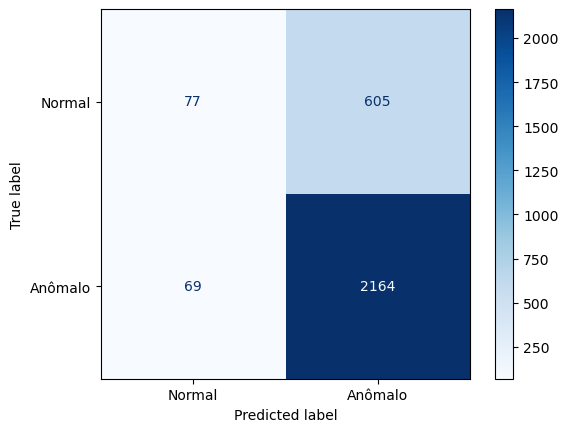

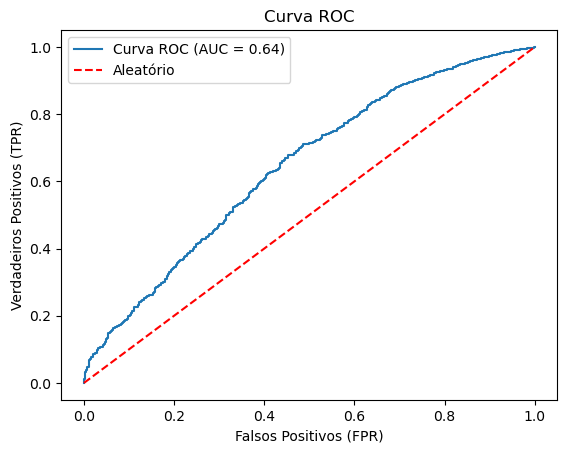

In [17]:
#IsolationForest sem balanceamento de dados

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

X_scaled = X
y_true = y

# Treinamento com ajuste de contaminação
model = IsolationForest(contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=100)

model.fit(X_scaled)

# Previsões
y_pred = model.predict(X_scaled)
y_pred_adjusted = np.where(y_pred == -1, 0, 1)

# Avaliação
print("Relatório de Classificação:")
print(classification_report(y_true, y_pred_adjusted, target_names=["Normal", "Anômalo"]))

# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anômalo"])
disp.plot(cmap='Blues')
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, model.decision_function(X_scaled))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'r--', label='Aleatório')
plt.title('Curva ROC')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdadeiros Positivos (TPR)')
plt.legend()
plt.show()



Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.39      0.04      0.07      2232
     Anômalo       0.49      0.94      0.65      2207

    accuracy                           0.49      4439
   macro avg       0.44      0.49      0.36      4439
weighted avg       0.44      0.49      0.36      4439



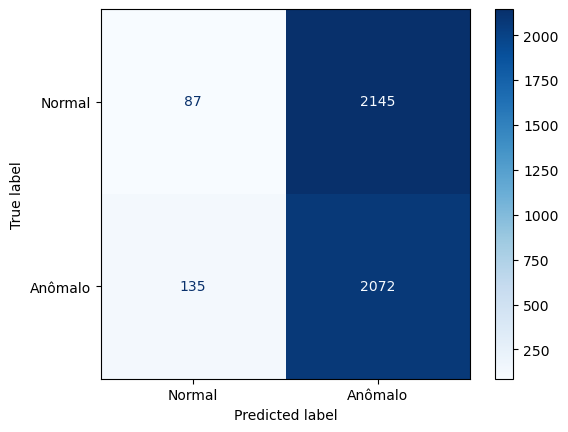

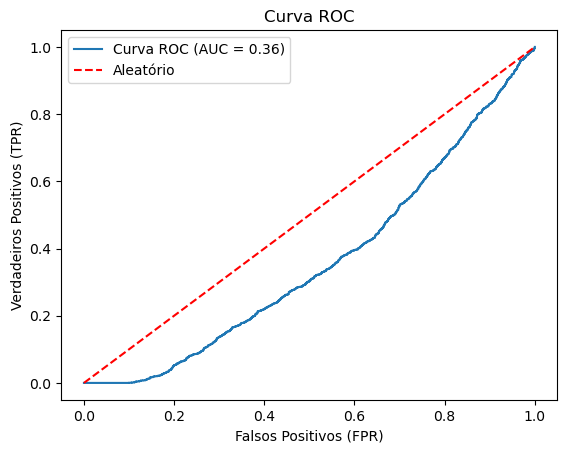

In [18]:
#IsolationForest com balanceamento de dados

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

y_true = y_resampled
X_scaled = X_resampled

# Treinamento com ajuste de contaminação
model = IsolationForest(contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=100)

model.fit(X_scaled)

# Previsões
y_pred = model.predict(X_scaled)
y_pred_adjusted = np.where(y_pred == -1, 0, 1)


# Avaliação
print("Relatório de Classificação:")
print(classification_report(y_true, y_pred_adjusted, target_names=["Normal", "Anômalo"]))

# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anômalo"])
disp.plot(cmap='Blues')
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, model.decision_function(X_scaled))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'r--', label='Aleatório')
plt.title('Curva ROC')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdadeiros Positivos (TPR)')
plt.legend()
plt.show()


Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.23      0.97      0.37       682
     Anômalo       0.66      0.02      0.04      2233

    accuracy                           0.24      2915
   macro avg       0.45      0.49      0.21      2915
weighted avg       0.56      0.24      0.12      2915



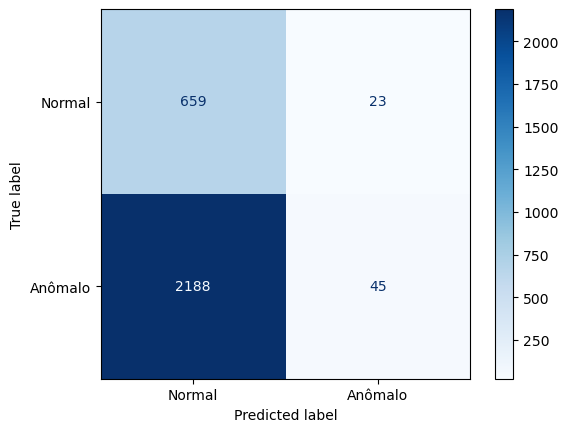

In [21]:
# modelo One-Class SVM

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

""" param_grid = {
    'nu': [0.01, 0.05, 0.1, 0.2],
    'gamma': ['auto', 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(OneClassSVM(kernel='rbf'), param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_scaled)

print("Melhores parâmetros:", grid_search.best_params_)
ocsvm = grid_search.best_estimator_"""

#Melhores parâmetros: {'gamma': 'auto', 'nu': 0.01}
# Inicializar o modelo One-Class SVM
# O parâmetro nu controla a fração esperada de anomalias (entre 0 e 1)
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # Ajuste gamma e nu conforme necessário

#ocsvm = OneClassSVM(kernel='linear', nu=0.1)
#ocsvm = OneClassSVM(kernel='poly', degree=3, nu=0.1)

# Treinar o modelo
ocsvm.fit(X)

# Prever as anomalias: -1 = anômalos, 1 = normais
y_pred = ocsvm.predict(X)

# Ajustar os valores de y_pred para comparação com y_true
y_pred_adjusted = np.where(y_pred == 1, 0, 1)  # 0 = normais, 1 = anômalos

# Comparar com os rótulos verdadeiros (y_true)
print("Relatório de Classificação:")
print(classification_report(y, y_pred_adjusted, target_names=["Normal", "Anômalo"]))

# Matriz de confusão
cm = confusion_matrix(y, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anômalo"])
disp.plot(cmap='Blues')
plt.show()




Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.51      0.99      0.67      2232
     Anômalo       0.69      0.02      0.04      2207

    accuracy                           0.51      4439
   macro avg       0.60      0.51      0.36      4439
weighted avg       0.60      0.51      0.36      4439



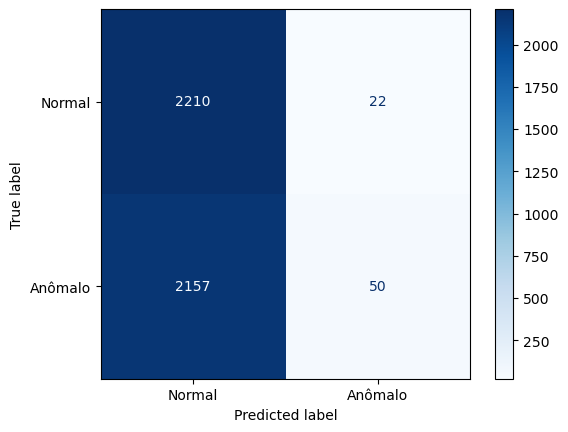

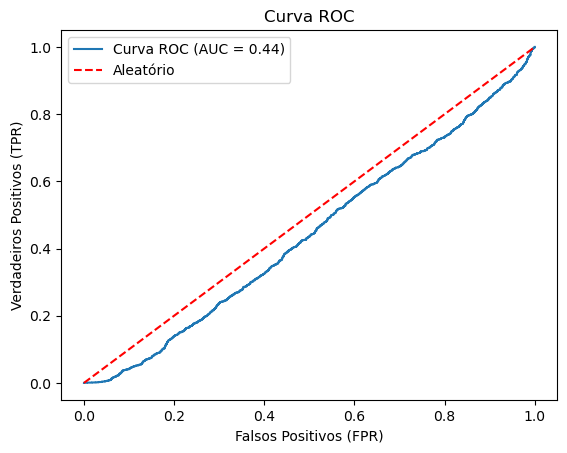

In [22]:
# modelo One-Class SVM com balanceamento

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

y = y_resampled
X = X_resampled
""" param_grid = {
    'nu': [0.01, 0.05, 0.1, 0.2],
    'gamma': ['auto', 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(OneClassSVM(kernel='rbf'), param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_scaled)

print("Melhores parâmetros:", grid_search.best_params_)
ocsvm = grid_search.best_estimator_"""

#Melhores parâmetros: {'gamma': 'auto', 'nu': 0.01}
# Inicializar o modelo One-Class SVM
# O parâmetro nu controla a fração esperada de anomalias (entre 0 e 1)
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)  # Ajuste gamma e nu conforme necessário

#ocsvm = OneClassSVM(kernel='linear', nu=0.1)
#ocsvm = OneClassSVM(kernel='poly', degree=3, nu=0.1)

# Treinar o modelo
ocsvm.fit(X)

# Prever as anomalias: -1 = anômalos, 1 = normais
y_pred = ocsvm.predict(X)

# Ajustar os valores de y_pred para comparação com y_true
y_pred_adjusted = np.where(y_pred == 1, 0, 1)  # 0 = normais, 1 = anômalos

# Comparar com os rótulos verdadeiros (y_true)
print("Relatório de Classificação:")
print(classification_report(y, y_pred_adjusted, target_names=["Normal", "Anômalo"]))

# Matriz de confusão
cm = confusion_matrix(y, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anômalo"])
disp.plot(cmap='Blues')
plt.show()



fpr, tpr, thresholds = roc_curve(y, ocsvm.decision_function(X))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'r--', label='Aleatório')
plt.title('Curva ROC')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdadeiros Positivos (TPR)')
plt.legend()
plt.show()


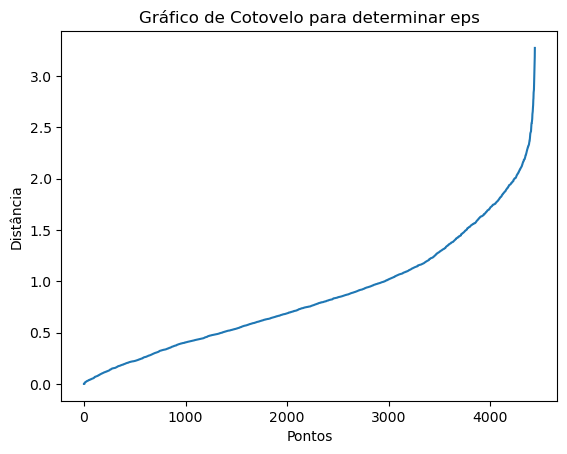

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.81      0.61      0.69      2232
     Anômalo       0.68      0.85      0.76      2207

    accuracy                           0.73      4439
   macro avg       0.74      0.73      0.72      4439
weighted avg       0.74      0.73      0.72      4439



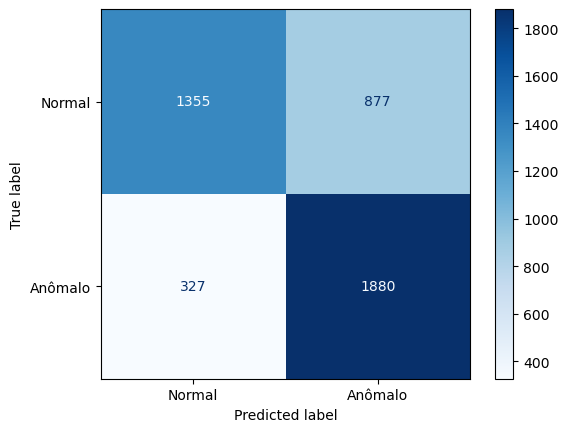

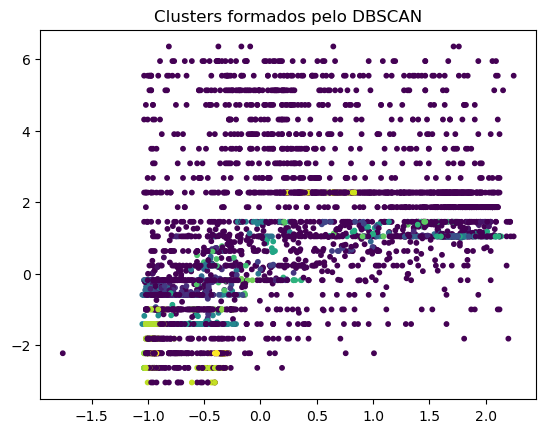

In [23]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, 4], axis=0)  # 4 = min_samples - 1
plt.plot(distances)
plt.title('Gráfico de Cotovelo para determinar eps')
plt.xlabel('Pontos')
plt.ylabel('Distância')
plt.show()

# Inicializar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Ajustar o modelo e prever os clusters
dbscan_labels = dbscan.fit_predict(X)

# Prever as anomalias: -1 = anômalos
y_pred_adjusted = np.where(dbscan_labels == -1, 1, 0)  # 1 = anômalos, 0 = normais

# Comparar com os rótulos verdadeiros (y_true)
print("Relatório de Classificação:")
print(classification_report(y, y_pred_adjusted, target_names=["Normal", "Anômalo"]))

# Matriz de confusão
cm = confusion_matrix(y, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anômalo"])
disp.plot(cmap='Blues')
plt.show()

# Visualização dos clusters (opcional)
plt.scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("Clusters formados pelo DBSCAN")
plt.show()


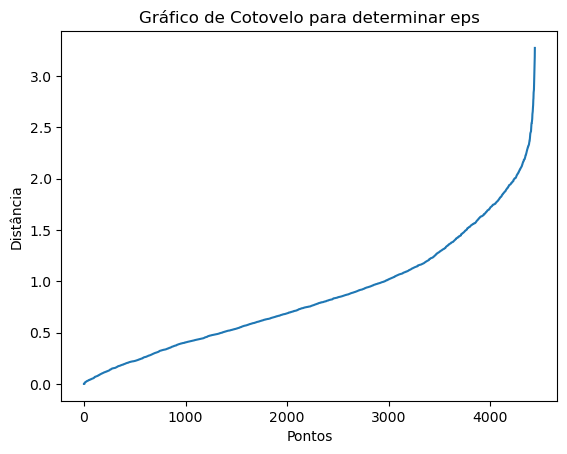

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.77      0.79      0.78      2232
     Anômalo       0.78      0.77      0.78      2207

    accuracy                           0.78      4439
   macro avg       0.78      0.78      0.78      4439
weighted avg       0.78      0.78      0.78      4439



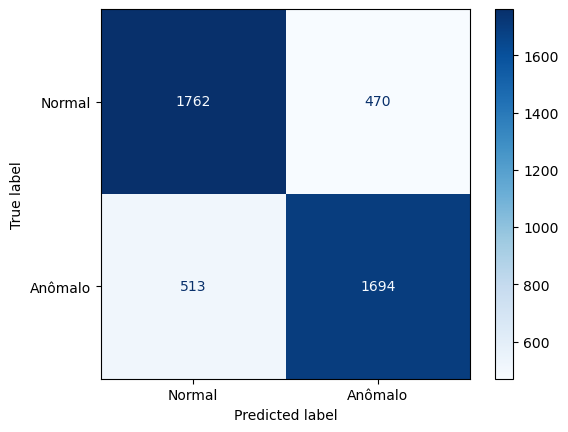

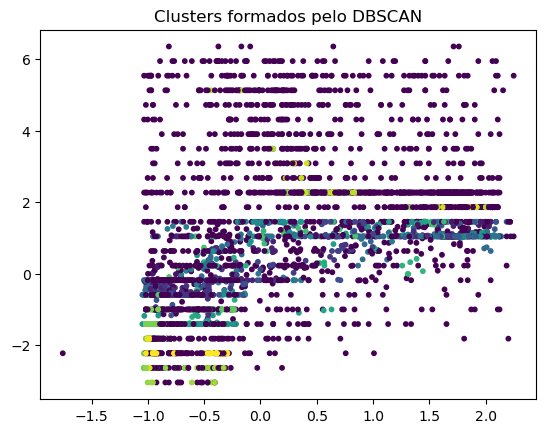

In [24]:
#DBSCAN com balanceamento

from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


from sklearn.cluster import DBSCAN

"""# Testando valores diferentes de eps e min_samples
best_eps = None
best_min_samples = None
best_f1 = 0

for eps in np.arange(0.1, 3.0, 0.1):
    for min_samples in range(3, 15):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        dbscan_labels = dbscan.fit_predict(X_resampled)
        y_pred_adjusted = np.where(dbscan_labels == -1, 1, 0)
        
        report = classification_report(y_resampled, y_pred_adjusted, output_dict=True)
        f1_score = report['weighted avg']['f1-score']
        
        if f1_score > best_f1:
            best_f1 = f1_score
            best_eps = eps
            best_min_samples = min_samples

print(f"Melhor eps: {best_eps}, Melhor min_samples: {best_min_samples}, Melhor F1-Score: {best_f1}")"""




y = y_resampled
X = X_resampled

from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, 4], axis=0)  # 4 = min_samples - 1
plt.plot(distances)
plt.title('Gráfico de Cotovelo para determinar eps')
plt.xlabel('Pontos')
plt.ylabel('Distância')
plt.show()

# Ajuste do DBSCAN
dbscan = DBSCAN(eps=.5, min_samples=3,  metric='euclidean')  # Ajuste eps e min_samples
dbscan_labels = dbscan.fit_predict(X)  # Usar X_pca para clusters em 2D (ou X_scaled para todas as features)

# Ajustar as previsões: -1 = anômalos, 1 = normais
y_pred_adjusted = np.where(dbscan_labels == -1, 1, 0)  # 1 = anômalos, 0 = normais

# Avaliar o desempenho
print("Relatório de Classificação:")
print(classification_report(y, y_pred_adjusted, target_names=["Normal", "Anômalo"]))

# Matriz de confusão
cm = confusion_matrix(y, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anômalo"])
disp.plot(cmap='Blues')
plt.show()

# Visualização dos clusters (opcional)
plt.scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("Clusters formados pelo DBSCAN")
plt.show()


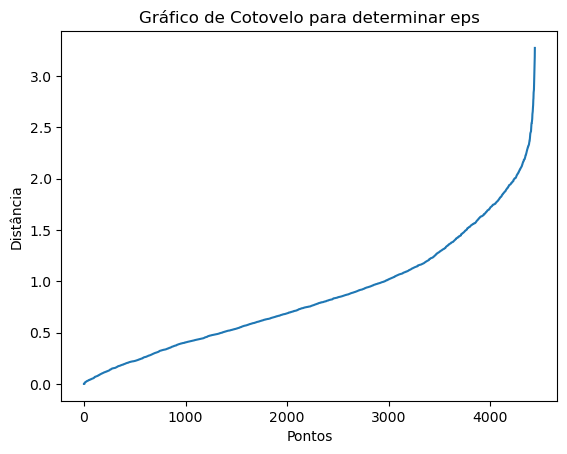

c:\conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.56      0.69      0.62      2232
     Anômalo       0.59      0.44      0.51      2207

    accuracy                           0.57      4439
   macro avg       0.57      0.57      0.56      4439
weighted avg       0.57      0.57      0.56      4439



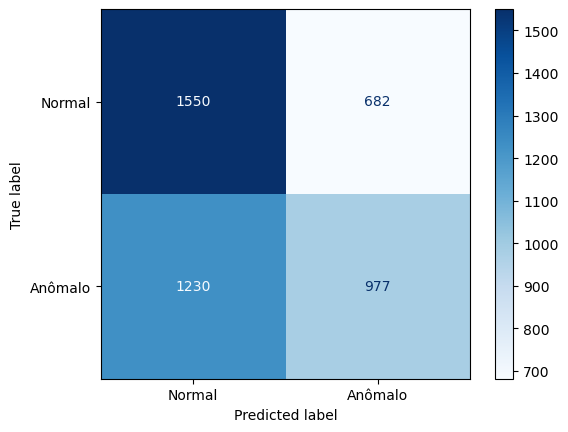

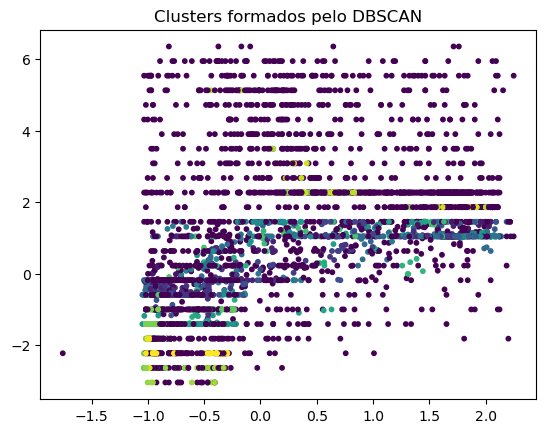

In [25]:
#DBSCAN com balanceamento

from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from hdbscan import HDBSCAN



from sklearn.cluster import DBSCAN

"""# Testando valores diferentes de eps e min_samples
best_eps = None
best_min_samples = None
best_f1 = 0

for eps in np.arange(0.1, 3.0, 0.1):
    for min_samples in range(3, 15):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        dbscan_labels = dbscan.fit_predict(X_resampled)
        y_pred_adjusted = np.where(dbscan_labels == -1, 1, 0)
        
        report = classification_report(y_resampled, y_pred_adjusted, output_dict=True)
        f1_score = report['weighted avg']['f1-score']
        
        if f1_score > best_f1:
            best_f1 = f1_score
            best_eps = eps
            best_min_samples = min_samples

print(f"Melhor eps: {best_eps}, Melhor min_samples: {best_min_samples}, Melhor F1-Score: {best_f1}")"""




y = y_resampled
X = X_resampled

from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, 4], axis=0)  # 4 = min_samples - 1
plt.plot(distances)
plt.title('Gráfico de Cotovelo para determinar eps')
plt.xlabel('Pontos')
plt.ylabel('Distância')
plt.show()


hdbscan = HDBSCAN(min_samples=3, min_cluster_size=5)
hdbscan_labels = hdbscan.fit_predict(X)

"""# Ajuste do DBSCAN
dbscan = DBSCAN(eps=.5, min_samples=3,  metric='euclidean')  # Ajuste eps e min_samples
dbscan_labels = dbscan.fit_predict(X)  # Usar X_pca para clusters em 2D (ou X_scaled para todas as features)""""FEATURE SELECTION.ipynb"


# Ajustar as previsões: -1 = anômalos, 1 = normais
y_pred_adjusted = np.where(hdbscan_labels == -1, 1, 0)  # 1 = anômalos, 0 = normais

# Avaliar o desempenho
print("Relatório de Classificação:")
print(classification_report(y, y_pred_adjusted, target_names=["Normal", "Anômalo"]))

# Matriz de confusão
cm = confusion_matrix(y, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anômalo"])
disp.plot(cmap='Blues')
plt.show()

# Visualização dos clusters (opcional)
plt.scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("Clusters formados pelo DBSCAN")
plt.show()


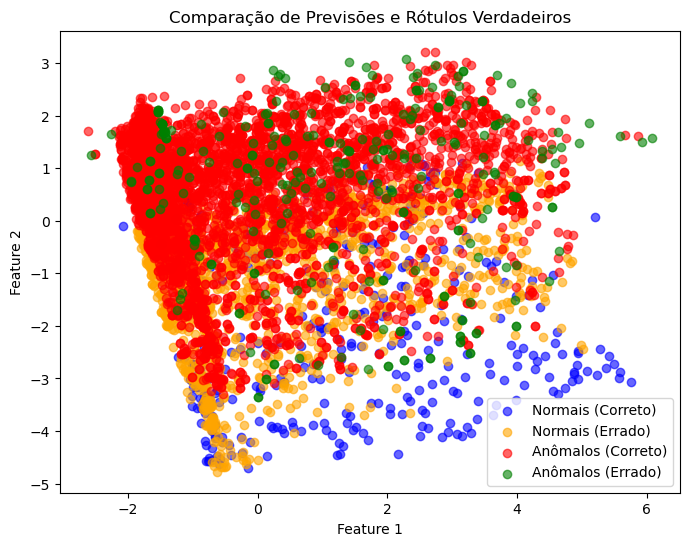

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.56      0.19      0.28      1995
     Anômalo       0.72      0.94      0.82      4567

    accuracy                           0.71      6562
   macro avg       0.64      0.56      0.55      6562
weighted avg       0.68      0.71      0.65      6562



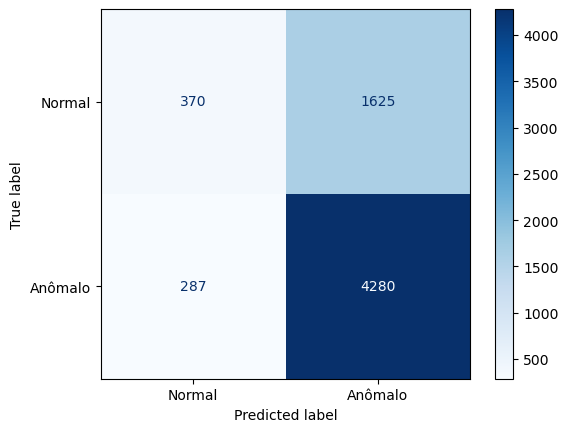

In [13]:
# teste

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Inicializar o modelo Isolation Forest
model = IsolationForest(contamination=0.1, random_state=42)

pca = PCA(n_components=6)  # Reduz para 2 componentes principais para visualização
X_pca = pca.fit_transform(X)  # X deve ser seu conjunto de dados original

# Treinar o modelo
model.fit(X_pca)

# Prever as anomalias
y_pred = model.predict(X_pca)  # 1 para anômalos, -1 para normais
y_true = y  # Certifique-se de que y está definido corretamente

# Ajustar as previsões para o formato dos rótulos verdadeiros
y_pred_adjusted = np.where(y_pred == -1, 0, 1)

# Visualizar os resultados
plt.figure(figsize=(8, 6))

# Rótulos verdadeiros (Normais)
plt.scatter(X_pca[(y_true == 0) & (y_pred_adjusted == 0), 0], 
            X_pca[(y_true == 0) & (y_pred_adjusted == 0), 1],
            label='Normais (Correto)', alpha=0.6, c='blue')

# Falsos negativos
plt.scatter(X_pca[(y_true == 0) & (y_pred_adjusted == 1), 0], 
            X_pca[(y_true == 0) & (y_pred_adjusted == 1), 1],
            label='Normais (Errado)', alpha=0.6, c='orange')

# Rótulos verdadeiros (Anômalos)
plt.scatter(X_pca[(y_true == 1) & (y_pred_adjusted == 1), 0], 
            X_pca[(y_true == 1) & (y_pred_adjusted == 1), 1],
            label='Anômalos (Correto)', alpha=0.6, c='red')

# Falsos positivos
plt.scatter(X_pca[(y_true == 1) & (y_pred_adjusted == 0), 0], 
            X_pca[(y_true == 1) & (y_pred_adjusted == 0), 1],
            label='Anômalos (Errado)', alpha=0.6, c='green')

plt.title('Comparação de Previsões e Rótulos Verdadeiros')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_true, y_pred_adjusted, target_names=["Normal", "Anômalo"]))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anômalo"])
disp.plot(cmap='Blues')
plt.show()


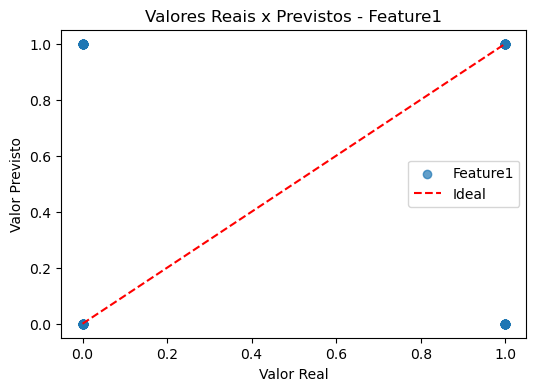

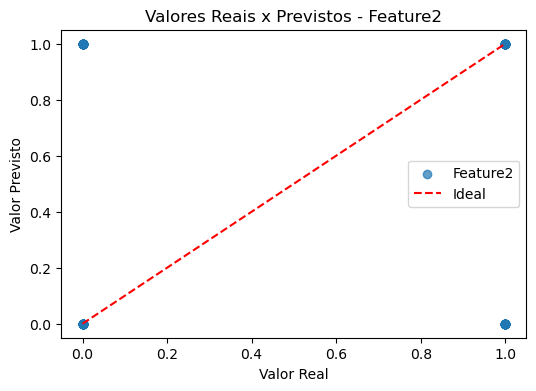

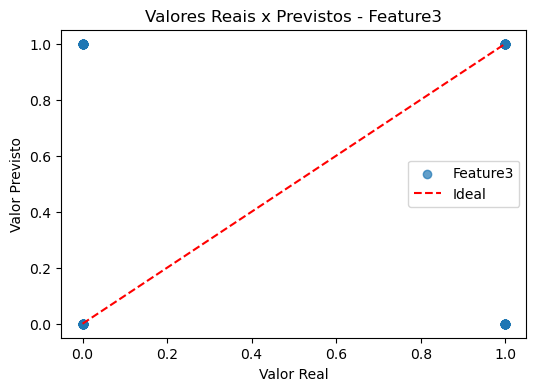

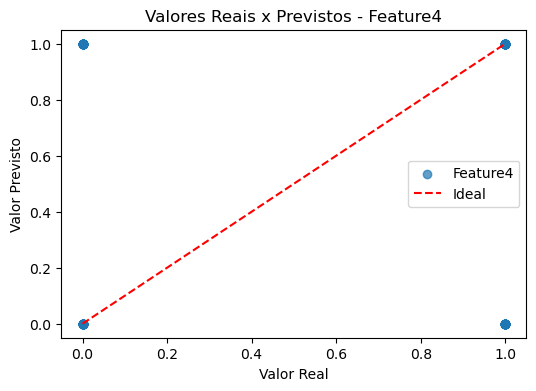

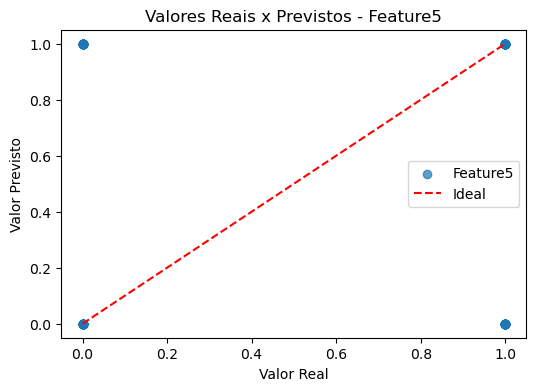

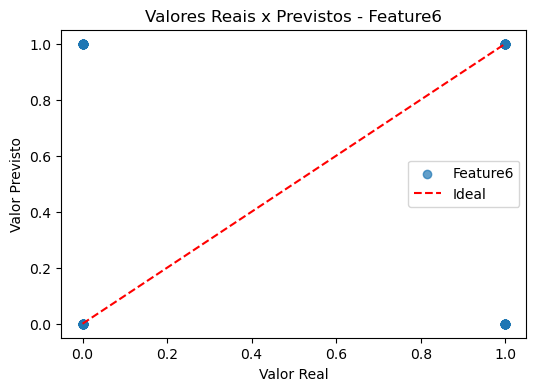

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Exemplo de dados
features = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6']
real_values = np.random.randint(0, 2, size=100)  # Valores reais (0 ou 1)
predicted_values = np.random.randint(0, 2, size=100)  # Valores previstos (0 ou 1)

# Gráfico para cada feature
for i, feature in enumerate(features):
    plt.figure(figsize=(6, 4))
    plt.scatter(real_values, predicted_values, alpha=0.7, label=f'{feature}')
    plt.plot([0, 1], [0, 1], 'r--', label='Ideal')  # Linha ideal
    plt.title(f'Valores Reais x Previstos - {feature}')
    plt.xlabel('Valor Real')
    plt.ylabel('Valor Previsto')
    plt.legend()
    plt.show()


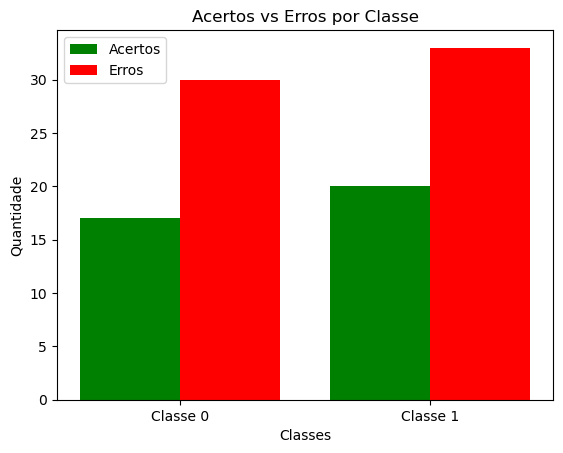

In [8]:
import matplotlib.pyplot as plt

# Dados de exemplo
real_values = np.random.randint(0, 2, size=100)
predicted_values = np.random.randint(0, 2, size=100)

# Contando acertos e erros
acertos_classe0 = sum((real_values == 0) & (predicted_values == 0))
acertos_classe1 = sum((real_values == 1) & (predicted_values == 1))
erros_classe0 = sum((real_values == 0) & (predicted_values == 1))
erros_classe1 = sum((real_values == 1) & (predicted_values == 0))

# Gráfico de barras
classes = ['Classe 0', 'Classe 1']
acertos = [acertos_classe0, acertos_classe1]
erros = [erros_classe0, erros_classe1]

bar_width = 0.4
index = np.arange(len(classes))

plt.bar(index, acertos, bar_width, label='Acertos', color='green')
plt.bar(index + bar_width, erros, bar_width, label='Erros', color='red')

plt.xlabel('Classes')
plt.ylabel('Quantidade')
plt.title('Acertos vs Erros por Classe')
plt.xticks(index + bar_width / 2, classes)
plt.legend()
plt.show()


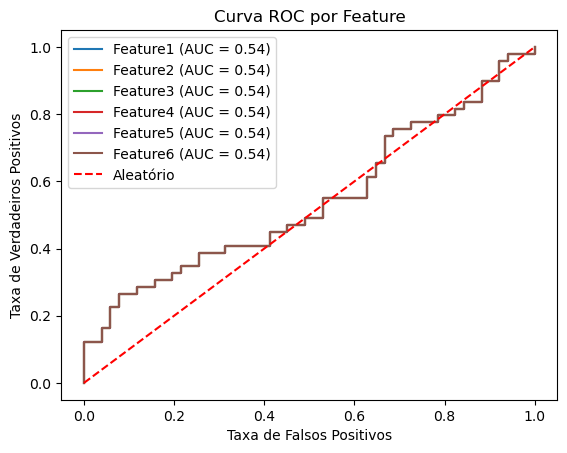

In [9]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Dados de exemplo
y_true = np.random.randint(0, 2, size=100)  # Valores reais
y_scores = np.random.rand(100)  # Pontuações previstas (probabilidades)

# Curva ROC para cada feature
for feature in features:
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{feature} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Aleatório')
plt.title('Curva ROC por Feature')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.show()


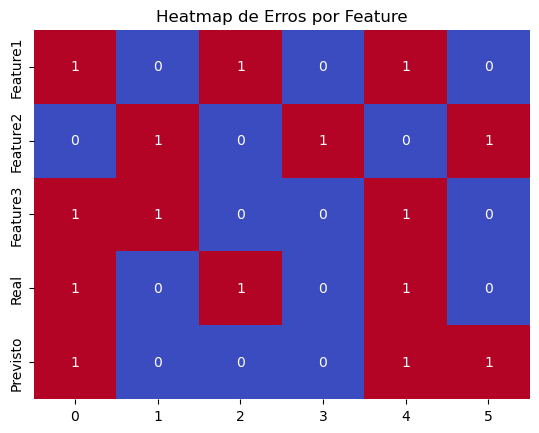

In [18]:
import seaborn as sns
import pandas as pd

# Exemplo de dados
data = pd.DataFrame({
    'Feature1': [1, 0, 1, 0, 1, 0],
    'Feature2': [0, 1, 0, 1, 0, 1],
    'Feature3': [1, 1, 0, 0, 1, 0],
    'Real': [1, 0, 1, 0, 1, 0],
    'Previsto': [1, 0, 0, 0, 1, 1]
})

# Criando a matriz de erro
data['Erro'] = (data['Real'] != data['Previsto']).astype(int)
sns.heatmap(data.iloc[:, :-1].T, annot=True, cmap='coolwarm', cbar=False)
plt.title('Heatmap de Erros por Feature')
plt.show()
